In [1]:
import os
import skimage
import cv2 as cv
import scipy as sp
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
image_path = os.path.join(os.getcwd(), "..", "dataset", "annotations2")
image_pairs = [
    (os.path.join(image_path, f), os.path.join(image_path, ".".join([f.split(".")[0][:-1] + "2", f.split(".")[-1]]))) 
    for f in list(filter(lambda f: f.split(".")[0][-1] == "1", os.listdir(image_path)))
]
measurement = list(filter(lambda f: f.split(".")[1] == "xlsx", os.listdir(image_path)))[0]
df = pd.read_excel(os.path.join(image_path, measurement))

In [3]:
def display_images(img1: np.array, img2: np.array) -> None:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    axes[0].imshow(img1, cmap="gray")
    axes[0].axis("off")
    axes[1].imshow(img2, cmap="gray")
    axes[1].axis("off")
    fig.tight_layout()

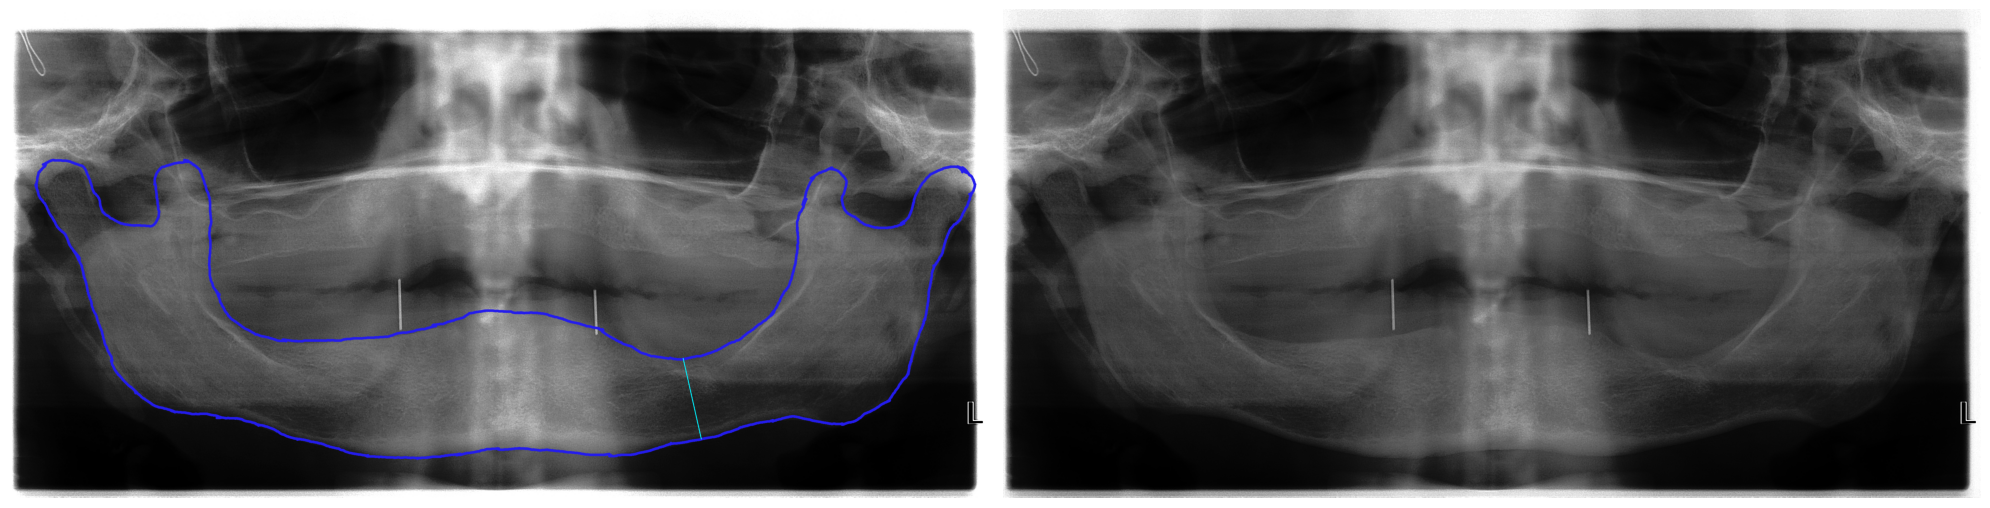

In [4]:
image_index = -1 # problems: 1
img_without_annotation = cv.imread(image_pairs[image_index][0])
img_with_annotation = cv.imread(image_pairs[image_index][1])
display_images(img_with_annotation, img_without_annotation)

## Get pin height

In [5]:
img_shape_y, img_shape_x = img_without_annotation.shape[:-1]
region_of_interest_min_x, region_of_interest_max_x = round(img_shape_x * 0.3), round(img_shape_x * 0.7)
region_of_interest_min_y, region_of_interest_max_y = round(img_shape_y * 0.4), round(img_shape_y * 0.8)

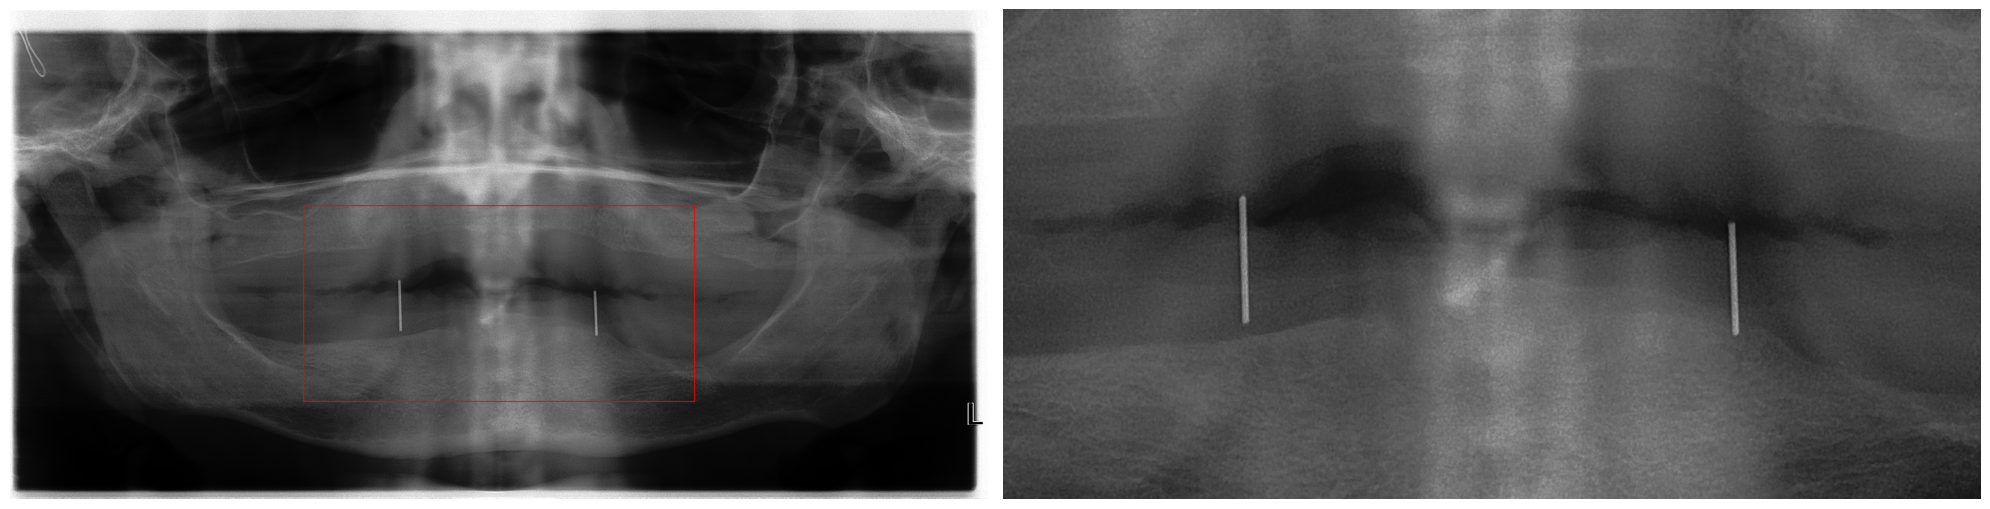

In [6]:
img = img_without_annotation.copy()
img_roi = img_without_annotation.copy()[region_of_interest_min_y:region_of_interest_max_y, region_of_interest_min_x:region_of_interest_max_x]
RED = (255, 0, 0)
BLUE = (0, 0, 255)
cv.rectangle(img, (region_of_interest_min_x, region_of_interest_min_y), (region_of_interest_max_x, region_of_interest_max_y), RED, 2)
display_images(img, img_roi)

$$
\text{scharr\_h} = \begin{bmatrix} -3 & -10 & -3 \\ 0 & 0 & 0 \\ 3 & 10 & 3 \end{bmatrix}
$$

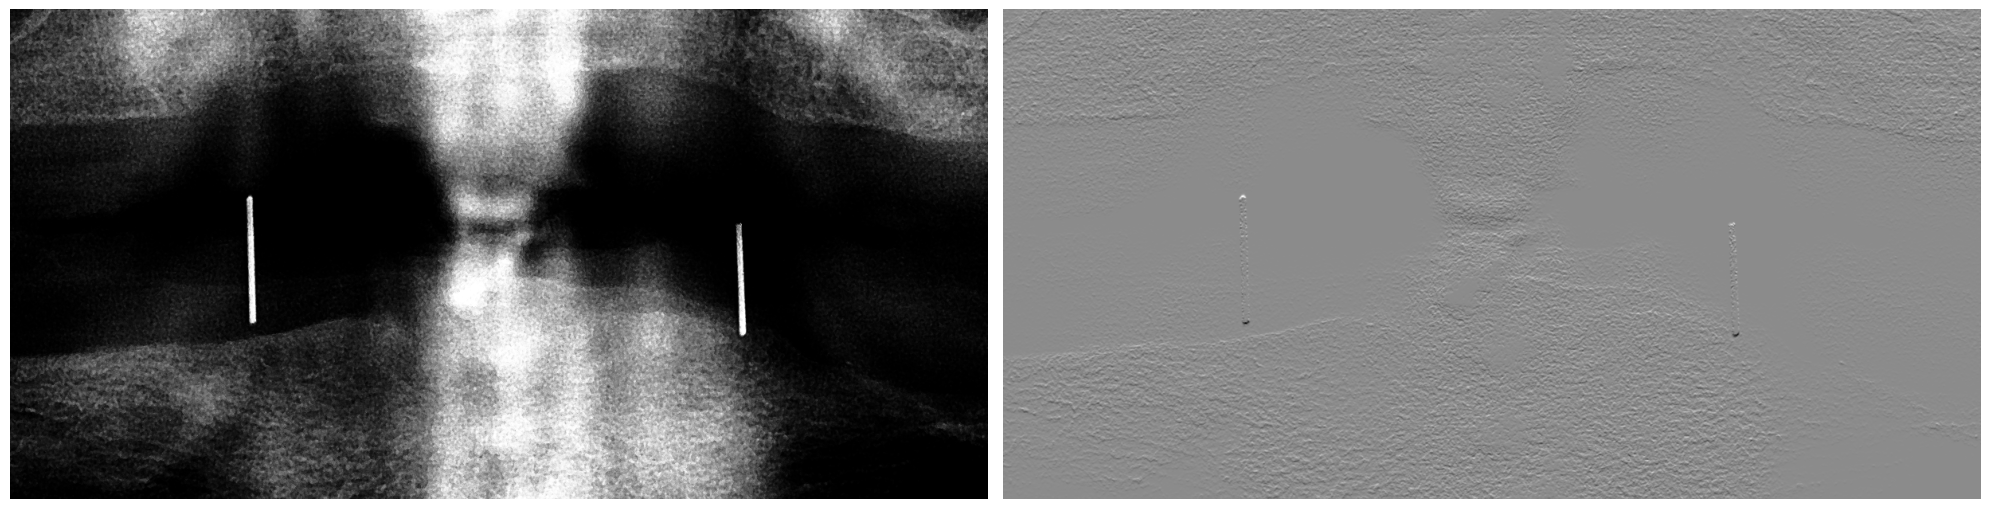

In [7]:
gray = cv.cvtColor(img_roi, cv.COLOR_BGR2GRAY)
equalized = skimage.exposure.equalize_hist(gray)
gamma_correct = skimage.exposure.adjust_gamma(equalized, 3)
scharr = skimage.filters.scharr_h(gamma_correct)

display_images(gamma_correct, scharr)

In [8]:
def get_pin_points(convolution_result: np.array) -> tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]:
    x_mid = round(convolution_result.shape[1] / 2)
    left = convolution_result[:, :x_mid]
    right = convolution_result[:, x_mid:]
    
    left_min = np.where(left == left.min())
    left_max = np.where(left == left.max())
    right_min = np.where(right == right.min())
    right_max = np.where(right == right.max())
    
    left_top, left_bottom = (left_max[1][0], left_max[0][0]), (left_min[1][0], left_min[0][0])
    right_top, right_bottom = (right_max[1][0] + x_mid, right_max[0][0]), (right_min[1][0] + x_mid, right_min[0][0])
    
    return (left_top, left_bottom), (right_top, right_bottom)

In [9]:
left_pin, right_pin = get_pin_points(scharr)

In [10]:
def draw_pin_line(img: np.array, left_pin: tuple[int, int], right_pin: tuple[int, int]):
    cv.circle(img, left_pin[0], 2, BLUE, 2)
    cv.circle(img, left_pin[1], 2, BLUE, 2)
    cv.circle(img, right_pin[0], 2, BLUE, 2)
    cv.circle(img, right_pin[1], 2, BLUE, 2)
    
    cv.line(img, left_pin[0], left_pin[1], RED, 2)
    cv.line(img, right_pin[0], right_pin[1], RED, 2)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

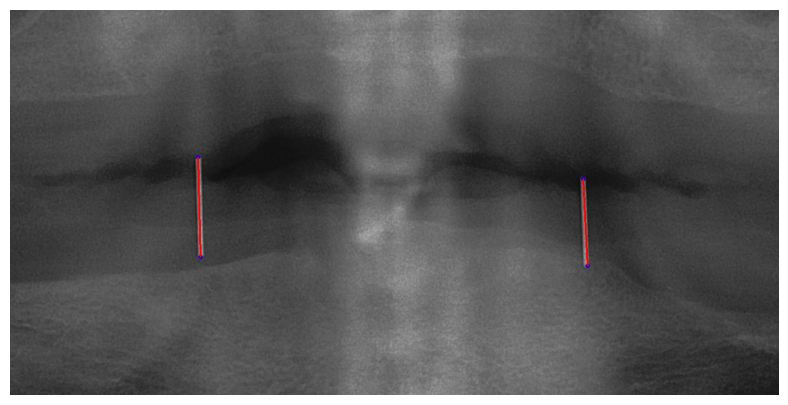

In [11]:
draw_pin_line(img_roi.copy(), left_pin, right_pin)

$\text{Pin height} = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$

In [12]:
def get_pin_height(left_pin: tuple[tuple[int, int], tuple[int, int]], right_pin: tuple[tuple[int, int], tuple[int, int]]) -> tuple[float, float]:
    left_x_top, left_y_top = left_pin[0][0], left_pin[0][1]
    left_x_bottom, left_y_bottom = left_pin[1][0], left_pin[1][1]
    right_x_top, right_y_top = right_pin[0][0], left_pin[0][1]
    right_x_bottom, right_y_bottom = right_pin[1][0], left_pin[1][1]
    
    left_height = np.sqrt((left_x_bottom - left_x_top) ** 2 + (left_y_bottom - left_y_top) ** 2)
    right_height = np.sqrt((right_x_bottom - right_x_top) ** 2 + (right_y_bottom - right_y_top) ** 2)
    
    return left_height, right_height

In [13]:
left_pin_height, right_pin_height = get_pin_height(left_pin, right_pin)

## Get mandible height

In [14]:
def get_annotation_line(img: np.array) -> np.array:
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    annotation_line = cv.inRange(hsv, (10, 0, 0), (255, 255, 255))
    mask = sp.ndimage.binary_fill_holes(annotation_line)
    edges = skimage.feature.canny(mask, sigma=9)
    return edges

In [15]:
mask = get_annotation_line(img_with_annotation)

In [16]:
def get_snake(edges: np.array) -> tuple[list[int, int], list[int, int]]:
    top_snake = []
    bottom_snake = []
    
    top_y1 = None
    bottom_y1 = None
    
    for x in range(edges.shape[1]):
        y_points = np.argwhere(edges[:, x] > 0).flatten()
        
        if y_points.shape[0] > 0:
            top_y2 = min(y_points)
            bottom_y2 = max(y_points)
            
            top_distance = abs(top_y2 - top_y1) if top_y1 != None else 0
            bottom_distance = abs(bottom_y2 - bottom_y1) if bottom_y1 != None else 0
            
            if top_distance > 10:
                top_loop = range(top_y1, top_y2, -1) if top_y1 > top_y2 else range(top_y1, top_y2)
                
                for y in top_loop:
                    top_left_boundary = x - 10 if x - 10 >= 0 else 0
                    
                    x_points = np.argwhere(edges[y, :] > 0)
                    
                    if x_points.shape[0] > 0:
                        top_snake.append([min(x_points[x_points > top_left_boundary]), y])
                        
            if bottom_distance > 10:
                 bottom_loop = range(bottom_y1, bottom_y2, -1) if bottom_y1 > bottom_y2 else range(bottom_y1, bottom_y2)
                 
                 for y in bottom_loop:
                    bottom_left_boundary = x - 10 if x - 10 >= 0 else 0
                    
                    x_points = np.argwhere(edges[y, :] > 0)
                    
                    if x_points.shape[0] > 0:
                        bottom_snake.append([min(x_points[x_points > bottom_left_boundary]), y])
                        
                            
            top_y1 = min(y_points)
            bottom_y1 = max(y_points)
            
            top_snake.append([x, min(y_points)])
            bottom_snake.append([x, max(y_points)])
            
    return np.array(top_snake), np.array(bottom_snake)

In [17]:
top_snake, bottom_snake = get_snake(mask)

In [18]:
def draw_snake(snake: np.array, edges: np.array) -> None:
    img = np.zeros((edges.shape[0], edges.shape[1]))
    
    for i in range(snake.shape[0]):
        cv.circle(img, snake[i], 1, (255, 255, 0), 1)
    
    display_images(img, edges)

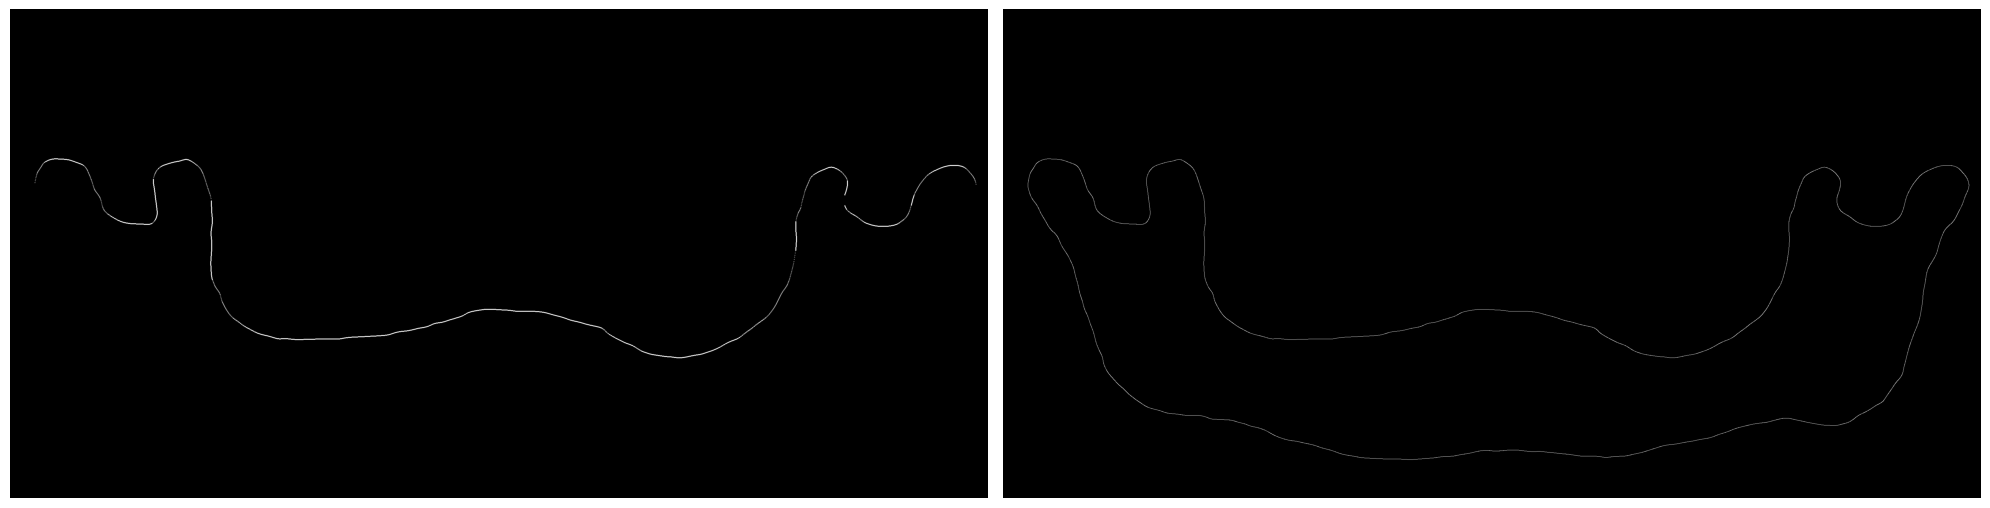

In [19]:
draw_snake(top_snake, mask)

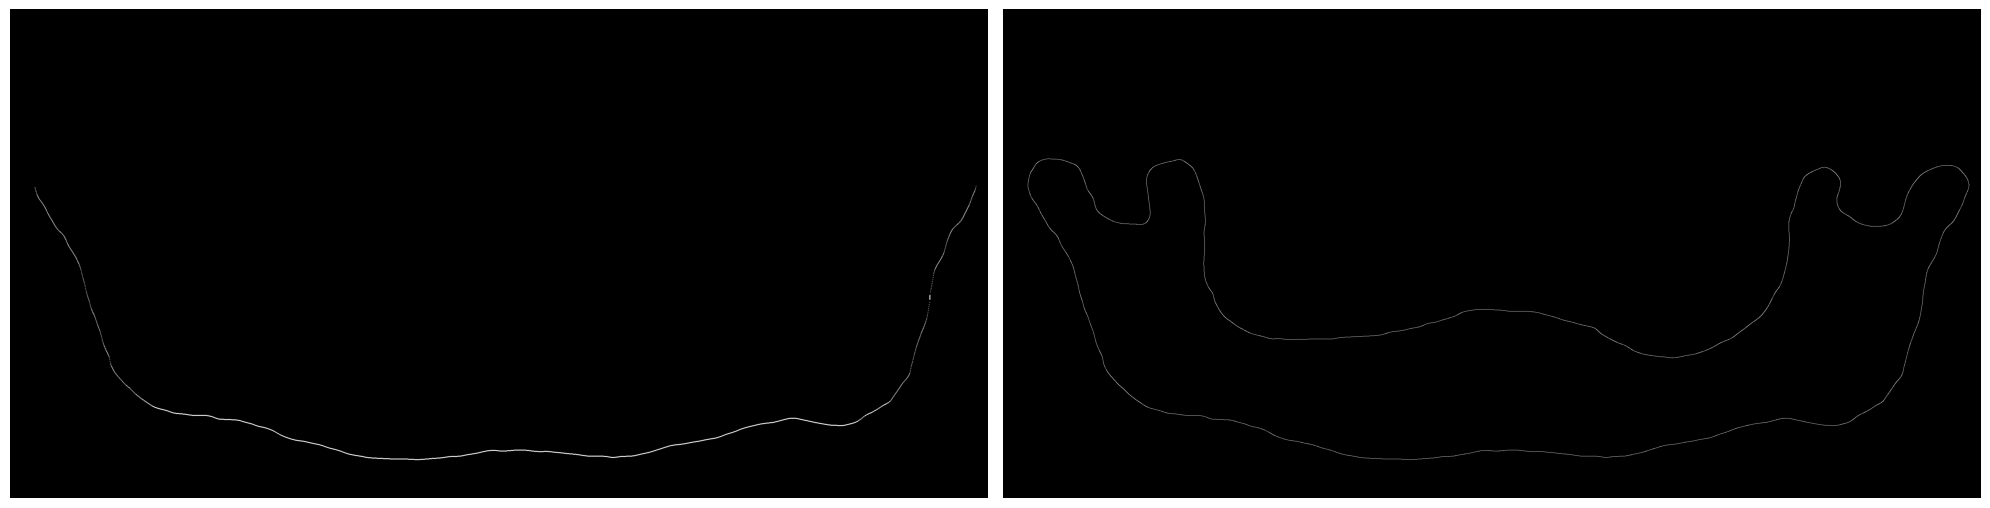

In [20]:
draw_snake(bottom_snake, mask)

In [21]:
def get_mandible_height(top_snake: np.array, bottom_snake: np.array) -> float:
    img = img_with_annotation.copy()
    
    min_y = min(top_snake.T[1])
    max_y = max(bottom_snake.T[1])
    
    top_boundary = round(min_y + (max_y - min_y) * 0.45)
    
    min_height = None
    
    p1_x, p1_y = (0, 0)
    p2_x, p2_y = (0, 0)
    
    for (x1, y1) in top_snake:
        if y1 >= top_boundary:
            i = 0
            for (x2, y2) in bottom_snake:
                i += 1
                height = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                
                if min_height == None or min_height > height:
                    min_height = height
                    p1_x, p2_x, p1_y, p2_y = x1, x2, y1, y2
                    
    measure_side = "right" if p1_x > img.shape[0] // 2 else "left"
                
    cv.line(img, (p1_x, p1_y), (p2_x, p2_y), (255, 255, 0), 2)
    
    display_images(img, img_with_annotation)
    
    return min_height, measure_side

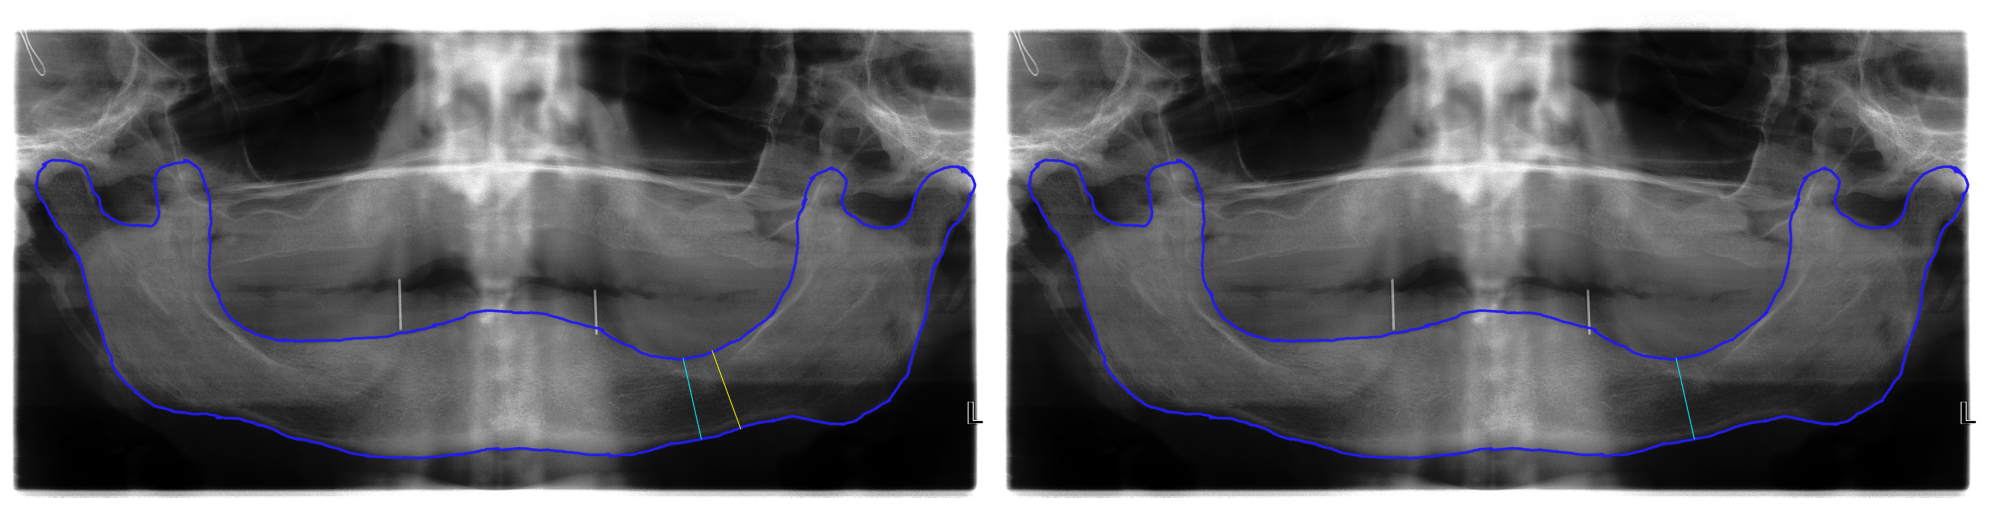

In [22]:
mandible_height_px, mandible_height_side = get_mandible_height(top_snake, bottom_snake)

In [23]:
mandible_height_px

261.9465594353169

## Check Result

In [24]:
df

Case Number  Mandible height 1st measurement  \
0      #911876                            40.07   
1      #909576                            12.15   
2     #0613818                            18.86   
3     #0413594                            16.04   
4     #0103924                            18.53   
5     #0104607                            19.04   
6     #0701332                            13.03   
7     #0206378                            16.97   
8     #0814472                            13.36   
9     #0714572                            19.21   
10    #0808121                            22.34   
11    #0708439                            13.39   
12    #0810504                            14.63   
13    #0900476                            20.64   
14    #1404021                            21.98   
15    #1000619                            18.22   
16    #0916815                            16.15   
17    #0904295                            13.09   
18    #1008906                            25.64   
19    #1405973                            17.47   

    Mandible height 2nd measurement  Mandible height 3rd measurement  \
0                             40.15                            40.24   
1                             12.29                            12.35   
2                             18.88                            18.79   
3                             16.57                            16.07   
4                             18.57                            18.79   
5                             18.65                            18.62   
6                             12.41                            12.67   
7                             17.19                            17.21   
8                             13.15                            13.21   
9                             19.06                            19.12   
10                            22.24                            22.31   
11                            13.58                            13.46   
12                            14.77                            14.69   
13                            20.99                            20.81   
14                            22.26                            21.04   
15                            18.08                            18.15   
16                            16.41                            16.61   
17                            13.08                            13.47   
18                            26.09                            25.87   
19                            17.08                            17.29   

    Type of mandible height  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  
0                         1         NaN         NaN         NaN         NaN  
1                         3         NaN         NaN         NaN         NaN  
2                         2         NaN         NaN         NaN         NaN  
3                         2         NaN         NaN         NaN         NaN  
4                         2         NaN         NaN         NaN         NaN  
5                         2         NaN         NaN         NaN         NaN  
6                         3       11.87       11.88       11.85         3.0  
7                         2       21.97       21.06       21.45         1.0  
8                         3       12.87       12.81       12.75         3.0  
9                         2       16.67       16.64       16.66         2.0  
10                        1       20.71       20.32       20.51         1.0  
11                        3       10.84       10.83       10.84         3.0  
12                        3       13.84       13.56       13.71         3.0  
13                        2       24.97       25.94       25.52         1.0  
14                        1       23.32       23.27       23.31         1.0  
15                        2         NaN         NaN         NaN         NaN  
16                        2         NaN         NaN         NaN         NaN  
17            

In [25]:
case_number = "#" + image_pairs[image_index][0].split("/")[-1].split(".")[0][:-2]
case_number

'#0714572'

In [26]:
df.loc[df["Case Number"] == case_number]

Case Number  Mandible height 1st measurement  \
9    #0714572                            19.21   

   Mandible height 2nd measurement  Mandible height 3rd measurement  \
9                            19.06                            19.12   

   Type of mandible height  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  
9                        2       16.67       16.64       16.66         2.0

In [27]:
def convert_measurement(mandible_height_px, pin_height):
    return (mandible_height_px / pin_height) * 10

In [28]:
pin_height = left_pin_height if mandible_height_side == "left" else right_pin_height

mandible_height_mm = convert_measurement(mandible_height_px, pin_height)

# Percent error

$\text{Percent Error} = \frac{(\text{measured value} - \text{actual value})}{\text{actual value}}$

$\text{Avg Percent Error} = (\frac{(\text{measured value} - \text{actual value 1})}{\text{actual value 1}} + \frac{(\text{measured value} - \text{actual value 2})}{\text{actual value 2}} + \frac{(\text{measured value} - \text{actual value 3})}{\text{actual value 3}}) \div 3$

In [29]:
mandible_height_mm

16.45868387122726

In [30]:
percent_error_1 = (mandible_height_mm - df.loc[df["Case Number"] == case_number]["Mandible height 1st measurement"]) / df.loc[df["Case Number"] == case_number]["Mandible height 1st measurement"]
percent_error_2 = (mandible_height_mm - df.loc[df["Case Number"] == case_number]["Mandible height 2nd measurement"]) / df.loc[df["Case Number"] == case_number]["Mandible height 2nd measurement"]
percent_error_3 = (mandible_height_mm - df.loc[df["Case Number"] == case_number]["Mandible height 3rd measurement"]) / df.loc[df["Case Number"] == case_number]["Mandible height 3rd measurement"]

avg_percent_error = abs((percent_error_1 + percent_error_2 + percent_error_3) / 3)
avg_percent_error

9    0.139631
dtype: float64

## Check annotation height

In [31]:
def get_annotation_mandible_height_line(img: np.array) -> float:
    img = img.copy()
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    mandible_height_line = cv.inRange(hsv, (1, 0, 255), (255, 255, 255))
    skeleton = skimage.morphology.skeletonize(mandible_height_line)
    
    line = np.argwhere(skeleton > 0)
    
    (y1, x1), (y2, x2) = line[0], line[-1]
    
    height = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    
    cv.circle(img, (x1, y1), 2, (255, 0, 0), 2)
    cv.circle(img, (x2, y2), 2, (255, 0, 0), 2)
    
    display_images(img, skeleton)
    
    return height

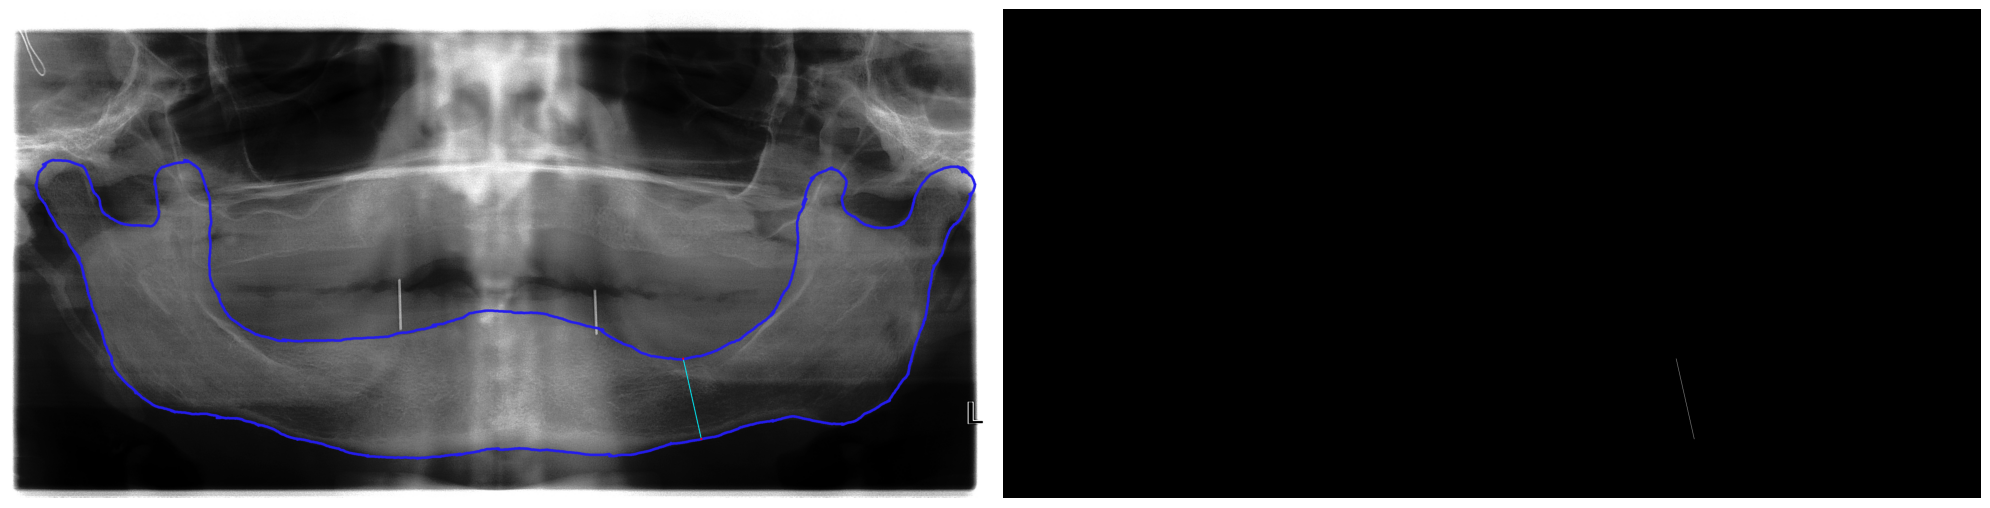

In [32]:
annotation_height = get_annotation_mandible_height_line(img_with_annotation)

In [33]:
annotation_height # from annotation

258.36601943754135

In [34]:
mandible_height_px

261.9465594353169

In [35]:
abs(mandible_height_px - annotation_height) # differences in pixel

3.5805399977755314

In [36]:
convert_measurement(annotation_height, right_pin_height)

16.23371059408741

In [37]:
df.loc[df["Case Number"] == case_number]

Case Number  Mandible height 1st measurement  \
9    #0714572                            19.21   

   Mandible height 2nd measurement  Mandible height 3rd measurement  \
9                            19.06                            19.12   

   Type of mandible height  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  
9                        2       16.67       16.64       16.66         2.0